# __Evaluación Modular - Módulo 8__
Autores: Aliwen Delgado, Constanza Valenzuela, Jose Miguel Ortiz, Viviana Molina

## _Clasificación de notas clínicas y evaluación de modelos NLP_

### _<u>Requerimientos</u>_
- Aplicar un pipeline completo de **procesamiento de lenguaje natural** en un dataset clínico.  
- Entrenar y comparar modelos tradicionales (Naive Bayes + TF-IDF) con modelos avanzados (Transformer).  
- Analizar el impacto del **sesgo** en subgrupos (género, edad).  
- Reflexionar sobre la importancia de la **ética, explicabilidad e interpretabilidad** en sistemas de NLP aplicados a salud.  


---

## Implementación

### **0. Importación de Librerías**

En esta sección cargamos todas las librerías necesarias para el flujo de trabajo.  
Cada una cumple un rol específico dentro del pipeline de **Procesamiento de Lenguaje Natural (NLP)** y evaluación de modelos de Machine Learning:

- **pandas y numpy**: Manipulación de datos tabulares y operaciones numéricas.  
- **matplotlib y seaborn**: Visualización de métricas, distribución de datos y resultados.  
- **re (expresiones regulares)**: Limpieza de texto, eliminación de caracteres especiales, URLs y correos.  
- **nltk (stopwords)**: Manejo de palabras vacías comunes en español.  
- **scikit-learn**:
  - `train_test_split`: División en conjunto de entrenamiento y prueba.  
  - `TfidfVectorizer`: Representación de texto en vectores numéricos mediante TF-IDF.  
  - `MultinomialNB`: Clasificador Naive Bayes multinomial, baseline clásico para texto.  
  - `classification_report` y `confusion_matrix`: Métricas de evaluación y matriz de confusión.  
  - `precision_recall_fscore_support`: Cálculo detallado de precisión, recall y F1 por subgrupos.  
- **Hugging Face (transformers / datasets / accelerate / evaluate)**: tokenizador, modelo BERT, entrenamiento con `Trainer` y métricas.
- **lime**: interpretabilidad local (LIME) para explicar decisiones de NB y BERT.


In [1]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización de resultados y métricas
import matplotlib.pyplot as plt
import seaborn as sns

# Expresiones regulares para limpiar texto
import re

# NLTK: procesamiento básico de lenguaje natural (stopwords en español)
import nltk
nltk.download('stopwords') # Descargar lista de stopwords
from nltk.corpus import stopwords

# Scikit-learn: modelado y vectorización
from sklearn.model_selection import train_test_split          # dividir train/test
from sklearn.feature_extraction.text import TfidfVectorizer   # vectorizar texto con TF-IDF
from sklearn.naive_bayes import MultinomialNB                 # clasificador Naive Bayes Multinomial

# Scikit-learn: métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prf

# Instalación de librerías de Transformers
!pip install -q -U transformers accelerate datasets evaluate

# Hugging Face: modelos, tokenización y entrenamiento
import torch, gc
import transformers, evaluate
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

# Interpretabilidad (LIME)
!pip install -q lime
from lime.lime_text import LimeTextExplainer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **1. Carga y Descripción del Dataset**

El dataset que utilizaremos es **`../data/raw/dataset_clinico_simulado_200.csv`**, el cual contiene **200 notas clínicas simuladas**.  
Las variables principales son:  
- **texto_clinico**: nota clínica en lenguaje natural.  
- **afeccion**: diagnóstico asociado.  
- **gravedad**: nivel de severidad de la condición (leve, moderado, severo).  
- **genero**: sexo del paciente (masculino/femenino).  
- **edad**: edad numérica del paciente (para análisis de sesgos por rango etario).  

> Este dataset servirá para **entrenar y evaluar modelos de clasificación multiclase**, además de explorar posibles sesgos en género y edad.

In [2]:
# Instalar gdown si no está presente (para descargar archivos desde Google Drive)
!pip install gdown

import gdown

# ID del archivo
file_id = "1pWlNKW31-MDEr6D8eNICjkadwLGeX2BR"
url = f"https://drive.google.com/uc?id={file_id}"

# Nombre de salida local
output = "../data/raw/dataset_clinico_simulado_200.csv"

# Descargar el archivo
gdown.download(url, output, quiet=False)

# Cargar el CSV
df = pd.read_csv(output)
print("Filas / Columnas:", df.shape)
df.head()


Downloading...
From: https://drive.google.com/uc?id=1pWlNKW31-MDEr6D8eNICjkadwLGeX2BR
To: /content/../data/raw/dataset_clinico_simulado_200.csv
100%|██████████| 20.9k/20.9k [00:00<00:00, 45.1MB/s]

Filas / Columnas: (200, 5)


,texto_clinico,edad,genero,afeccion,gravedad
0,El paciente presenta síntomas leves como dolor...,43,M,resfriado común,leve
1,Consulta por hipertensión leve sin signos de a...,34,F,hipertensión leve,leve
2,"Evolución rápida del cuadro clínico, compatibl...",34,M,infarto agudo de miocardio,severo
3,El paciente presenta síntomas leves como tos y...,58,M,gastroenteritis,leve
4,"El cuadro clínico indica asma, con síntomas co...",45,M,asma,moderado


Antes de procesar, confirmamos la **estructura del dataset** y revisamos una **muestra aleatoria** para validar que las variables clave estén presentes.

- `texto_clinico`: nota en lenguaje natural (fuente principal).
- `afeccion`: diagnóstico asociado.
- `gravedad`: etiqueta de salida (**leve / moderado / severo**).
- `genero`, `edad`: metadatos útiles para **análisis de sesgos**.

> Esta verificación evita errores de nombres de columnas y nos asegura que el texto a vectorizar está correctamente identificado.

In [3]:
# Ver columnas y ejemplo de datos
print(df.columns.tolist())

df.sample(5) # otras 5 random

['texto_clinico', 'edad', 'genero', 'afeccion', 'gravedad']


,texto_clinico,edad,genero,afeccion,gravedad
197,Consulta por hipertensión leve sin signos de a...,34,M,hipertensión leve,leve
141,El paciente muestra signos severos como fiebre...,80,M,neumonía,severo
88,El paciente muestra signos severos como dolor ...,24,F,insuficiencia renal aguda,severo
51,"Evolución rápida del cuadro clínico, compatibl...",75,F,insuficiencia renal aguda,severo
133,"Urgencia médica por dolor abdominal, asociado ...",39,F,fractura de muñeca,severo


## **2. Preprocesamiento de texto (limpieza + lematización)**

Aplicamos un pipeline claro y reproducible para dejar el texto listo para vectorizar (TF-IDF) y modelar:

1. **Limpieza básica**: minúsculas, eliminar URLs/emails, signos y números → reduce ruido.  
2. **Tokenización**: segmentar en palabras (simple con `split()` o lingüística con spaCy).  
3. **Stopwords**: remover palabras muy frecuentes sin aporte semántico.  
4. **Lematización (opcional)** con `spaCy`: normaliza a la **forma base** →  mejora generalización (ej. “corriendo” → “correr”)
5. **Salida**: `texto_proc` (string), listo para **TF-IDF** (`TfidfVectorizer`) y modelado.

In [4]:
stop_es = set(stopwords.words("spanish"))

def limpiar_texto(s: str) -> str:
    """
    Limpia texto crudo y lo deja normalizado.

    Parámetros
        s : str
            Texto original (puede contener mayúsculas, signos, URLs, emails, números).

    Retorna
        str
            Texto en minúsculas, sin URLs/emails, sin signos ni números, con espacios normalizados.
    """
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+|\S+@\S+", " ", s)        # eliminar URLs y correos
    s = re.sub(r"[^a-záéíóúñü\s]", " ", s)               # mantener solo letras/espacios
    s = re.sub(r"\s+", " ", s).strip()                   # compactar espacios
    return s

def tokenizar_simple(s: str) -> list[str]:
    """
    Tokeniza por espacios (tokenización simple).

    Parámetros
        s : str
            Texto ya limpio o crudo.
    Retorna
        list[str]
            Lista de tokens (palabras).
    """
    return s.split()

def quitar_stopwords(tokens: list[str]) -> list[str]:
    """
    Elimina stopwords y tokens muy cortos.
    Parámetros
        tokens : list[str]
            Lista de tokens (salida de tokenización simple o spaCy).
    Retorna
        list[str]
            Tokens sin stopwords y con longitud > 2.
    """
    return [w for w in tokens if w not in stop_es and len(w) > 2]

# --- Pipeline básico (sin spaCy) ---
# 1) Limpieza
df["texto_limpio"] = df["texto_clinico"].apply(limpiar_texto)
# 2) Tokenización simple
df["tokens"] = df["texto_limpio"].apply(tokenizar_simple)
# 3) Stopwords
df["tokens"] = df["tokens"].apply(quitar_stopwords)
# 4) Reconstruir string procesado (para TF-IDF)
df["texto_proc"] = df["tokens"].apply(lambda toks: " ".join(toks))

# Vista rápida
df[["texto_clinico", "texto_limpio", "tokens", "texto_proc"]].head(3)

,texto_clinico,texto_limpio,tokens,texto_proc
0,El paciente presenta síntomas leves como dolor...,el paciente presenta síntomas leves como dolor...,"[paciente, presenta, síntomas, leves, dolor, c...",paciente presenta síntomas leves dolor cabeza ...
1,Consulta por hipertensión leve sin signos de a...,consulta por hipertensión leve sin signos de a...,"[consulta, hipertensión, leve, signos, alarma]",consulta hipertensión leve signos alarma
2,"Evolución rápida del cuadro clínico, compatibl...",evolución rápida del cuadro clínico compatible...,"[evolución, rápida, cuadro, clínico, compatibl...",evolución rápida cuadro clínico compatible inf...


### **2.1 (Opcional) Tokenización + Lematización con spaCy**

Si desamos dispones de `spaCy`, se puede reemplazar la tokenización simple por una **tokenización lingüística** y aplicar **lematización** para normalizar palabras a su forma base.  

Esto suele mejorar la generalización del modelo, especialmente en dominios con mucha variación morfológica.

> **Nota**: Ejecutar la descarga del modelo español solo la primera vez.

In [5]:
# # ¡Ejecutar SOLO la primera vez!
# !python -m spacy download es_core_news_sm

# import spacy
# nlp = spacy.load("es_core_news_sm")

# def lematizar_spacy(s: str) -> list[str]:
#     """
#     Tokeniza y lematiza con spaCy, filtrando stopwords, signos y tokens cortos.
#     Parámetros
#         s : str
#             Texto ya limpio o crudo.
#     Retorna
#         list[str]
#             Lemas significativos (p.ej., 'corriendo' -> 'correr').
#     """
#     doc = nlp(s)
#     return [
#         t.lemma_ for t in doc
#         if (t.lemma_ not in stop_es) and (len(t.lemma_) > 2)
#         and (not t.is_punct) and (not t.is_space)
#     ]

# # Para usar spaCy, descomenta estas líneas:
# df["texto_limpio"] = df["texto_clinico"].apply(limpiar_texto)
# df["tokens"]       = df["texto_limpio"].apply(lematizar_spacy)
# df["texto_proc"]   = df["tokens"].apply(lambda toks: " ".join(toks))
# df[["texto_clinico", "texto_limpio", "tokens", "texto_proc"]].head(3)


### **2.2 Indicadores del corpus (antes vs después)**

Luego medimos el efecto del preprocesamiento en:
- **Longitud promedio** (palabras por nota)
- **Tamaño del vocabulario** (palabras únicas)
- **Palabras totales**

> Un descenso controlado indica menos ruido y mayor **consistencia semántica** para la vectorización.


In [6]:
def stats_textos(serie: pd.Series) -> dict:
    """
    Calcula indicadores básicos de una serie de textos.
    Parámetros
        serie : pd.Series
            Serie de strings.
    Retorna
        dict
            {'longitud_promedio', 'tamaño_vocabulario', 'palabras_totales'}
    """
    toks = serie.astype(str).str.split()
    longitudes = toks.map(len)
    vocab = set([w for doc in toks for w in doc])
    return {
        "longitud_promedio": longitudes.mean(),
        "tamaño_vocabulario": len(vocab),
        "palabras_totales": longitudes.sum()
    }

stats_original  = stats_textos(df["texto_clinico"])
stats_limpio    = stats_textos(df["texto_limpio"])
stats_procesado = stats_textos(df["texto_proc"])

print("=== Original ===", stats_original)
print("=== Limpio   ===", stats_limpio)
print("=== Procesado===", stats_procesado)

comparacion = pd.DataFrame([
    {"Etapa":"Original",  **stats_original},
    {"Etapa":"Limpio",    **stats_limpio},
    {"Etapa":"Procesado", **stats_procesado},
]).set_index("Etapa")

display(comparacion.style.format({"longitud_promedio":"{:.2f}"}))

=== Original === {'longitud_promedio': np.float64(10.41), 'tamaño_vocabulario': 115, 'palabras_totales': np.int64(2082)}
=== Limpio   === {'longitud_promedio': np.float64(10.22), 'tamaño_vocabulario': 84, 'palabras_totales': np.int64(2044)}
=== Procesado=== {'longitud_promedio': np.float64(6.95), 'tamaño_vocabulario': 70, 'palabras_totales': np.int64(1390)}


,longitud_promedio,tamaño_vocabulario,palabras_totales
Etapa,,,
Original,10.41,115,2082
Limpio,10.22,84,2044
Procesado,6.95,70,1390


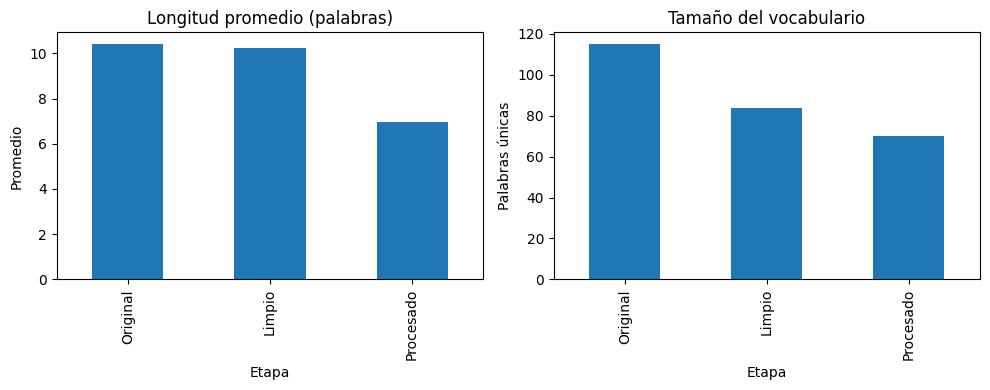

In [7]:
# Gráfico comparativo: longitud y vocabulario
fig, ax = plt.subplots(1, 2, figsize=(10,4))

comparacion["longitud_promedio"].plot(kind="bar", ax=ax[0])
ax[0].set_title("Longitud promedio (palabras)")
ax[0].set_ylabel("Promedio")
ax[0].set_xlabel("Etapa")

comparacion["tamaño_vocabulario"].plot(kind="bar", ax=ax[1])
ax[1].set_title("Tamaño del vocabulario")
ax[1].set_ylabel("Palabras únicas")
ax[1].set_xlabel("Etapa")

plt.tight_layout()
plt.show()

<u>**Analisis rápido de resultados**</u>
- La **longitud promedio** y el **vocabulario** disminuyen tras procesar → señal de **menos ruido**.
- Mantener `texto_proc` como string garantiza compatibilidad inmediata con **TF-IDF**.
- Si el dominio tiene mucha variación morfológica, la **lematización** suele aportar estabilidad adicional.

> Con este `texto_proc` ya podemos pasar a **vectorización (TF-IDF)** y **modelado** sin sorpresas.


## **3. Modelado**

En esta etapa entrenamos y comparamos dos enfoques para la clasificación multiclase (**leve, moderado, severo**):

1. **Modelo tradicional**  
   - Basado en **Naive Bayes Multinomial** sobre vectores **TF-IDF**.  
   - Es rápido, eficiente y un buen *baseline* para textos cortos.

2. **Modelo avanzado**  
   - Un **Transformer multilingüe** (`bert-base-multilingual-cased`) ajustado (**fine-tuning**) con nuestro dataset clínico.  
   - Este modelo aprende representaciones contextuales profundas, capturando mejor la semántica del texto.  
   - A cambio, requiere mayor poder computacional y tiempo de entrenamiento.  
   > **Importante**: este modelo está preentrenado para **análisis de sentimiento (1–5 estrellas)**, no para gravedad clínica (*leve/moderado/severo*). Lo usamos aquí solo como **demostración de uso de Transformers**.  
   >   - Para el caso clínico real sería necesario hacer **fine-tuning** con nuestro dataset etiquetado.  

> De este modo, podemos comparar un método clásico (rápido y ligero) con uno moderno (más costoso pero con mejor capacidad de generalización).



### **3.1 Modelo tradicional (Naive Bayes + TF-IDF)**

En este primer enfoque:  

1. Se divide el corpus en **train/test** (80/20, estratificado).  
2. Se representa cada texto mediante **TF-IDF**, considerando unigramas y bigramas.  
3. Se entrena un clasificador **Naive Bayes Multinomial**.  

Este modelo nos servirá como referencia inicial para evaluar qué tanto mejora un Transformer más avanzado.


In [8]:
# === 3.1 Preparación de variables ===
# Target: columna "gravedad" (clases: leve, moderado, severo)
y = df["gravedad"].astype(str)

# Features: texto preprocesado
X_text = df["texto_proc"]

# División train/test estratificada (mantiene proporciones de cada clase)
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,        # 20% para test
    random_state=42,      # reproducibilidad
    stratify=y            # asegura proporciones iguales en train/test
)


In [9]:
# === 3.2 Vectorización con TF-IDF ===
# TF-IDF con unigramas y bigramas, descartando términos muy raros y muy frecuentes
tfidf = TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1,2))

# Ajuste en train + transformación en train/test
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

print("Dimensiones TF-IDF (train):", Xtr.shape)


Dimensiones TF-IDF (train): (160, 196)


In [10]:
# === 3.3 Entrenamiento de modelo baseline ===
# Modelo Naive Bayes Multinomial (baseline)
nb = MultinomialNB()

# Ajustar con TF-IDF de entrenamiento
nb.fit(Xtr, y_train)

print("[OK] Modelo entrenado con TF-IDF + Naive Bayes")

[OK] Modelo entrenado con TF-IDF + Naive Bayes


### **3.2 Modelo avanzado (BERT multilingüe fine-tuned)**

En este enfoque usamos un **Transformer multilingüe** (`bert-base-multilingual-cased`) y lo entrenamos en nuestro dataset clínico.  

Pasos aplicados:  
1. **Mapeo de etiquetas**: se convierten las clases (*leve, moderado, severo*) en IDs numéricos.  
2. **Creación de datasets**: se estructuran en el formato de Hugging Face (`DatasetDict`).  
3. **Tokenización**: los textos se convierten en vectores de sub-tokens.  
4. **Modelo**: se carga BERT con una capa de clasificación adaptada a 3 etiquetas.  
5. **Entrenamiento**: con `Trainer`, usando métricas de **accuracy** y **F1 macro**.  
6. **Evaluación**: se generan reportes por clase y una matriz de confusión.  

> **Nota**: también existe el modelo `nlptown/bert-base-multilingual-uncased-sentiment`, preentrenado para *sentimiento (1–5 estrellas)*. Puede usarse como *demo*, pero no es comparable con nuestro caso de *gravedad clínica*, por lo que aquí preferimos realizar **fine-tuning**.


In [11]:
# === 3.2.1 Demo con Transformer multilingüe ===
#!pip install transformers -q
# from transformers import pipeline
# Pipeline de clasificación de texto con BERT multilingüe preentrenado
#clf = pipeline("text-classification",
#               model="nlptown/bert-base-multilingual-uncased-sentiment")

# Probar con algunas notas del conjunto de test
#ejemplos = X_test.sample(5, random_state=1).tolist()
#preds = clf(ejemplos)

#for txt, pred in zip(ejemplos, preds):
#    print(f"Texto: {txt[:80]}...")
#    print(f"Predicción Transformer: {pred}")
#    print("-"*60)


In [12]:
# =========================================================
# 3.2.2 Modelo avanzado (M2): BERT multilingüe fine-tuned
#   - Robusto a versiones: usa evaluation_strategy cuando esté disponible
#   - Si tu runtime no acepta ese argumento, cae a modo compat
# =========================================================

# 1) Instalar/actualizar dependencias para Transformers (una vez por runtime)
print("Transformers versión:", transformers.__version__)
use_fp16 = torch.cuda.is_available()

# 2) Etiquetas y mapeos
labels = sorted(y_train.astype(str).unique())              # ['leve','moderado','severo']
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
print("Clases:", labels)

# 3) Datasets Hugging Face
train_ds = Dataset.from_dict({
    "text": X_train.tolist(),
    "label": y_train.map(label2id).tolist()
})
test_ds = Dataset.from_dict({
    "text": X_test.tolist(),
    "label": y_test.map(label2id).tolist()
})
ds = DatasetDict({"train": train_ds, "test": test_ds})

# 4) Tokenización
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)

tok_ds = ds.map(tokenize_fn, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer)

# 5) Modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# 6) Métricas (eval)
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=1)
    return {
        "accuracy": metric_acc.compute(predictions=y_pred, references=y_true)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=y_pred, references=y_true, average="macro")["f1"]
    }

# 7) TrainingArguments (con fallback si la versión no soporta evaluation_strategy)
def make_training_args():
    try:
        # Intento con argumentos modernos
        return TrainingArguments(
            output_dir="./mbert_gravedad",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            learning_rate=2e-5,
            weight_decay=0.01,
            fp16=use_fp16,
            logging_steps=50,
            report_to="none",
            seed=42
        )
    except TypeError:
        # Fallback para entornos antiguos
        return TrainingArguments(
            output_dir="./mbert_gravedad",
            do_eval=True,
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            learning_rate=2e-5,
            weight_decay=0.01,
            fp16=use_fp16,
            logging_steps=50,
            save_total_limit=1,
            report_to="none",
            seed=42
        )

args = make_training_args()

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 8) Entrenamiento + evaluación (compat con ambos modos)
trainer.train()
eval_metrics = trainer.evaluate()
print("=== Métricas globales (BERT) ===", {k: (round(v,4) if isinstance(v,float) else v)
                                          for k,v in eval_metrics.items()})

Transformers versión: 4.56.0
Clases: ['leve', 'moderado', 'severo']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1290637841.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


=== Métricas globales (BERT) === {'eval_loss': 0.2426, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.1058, 'eval_samples_per_second': 378.06, 'eval_steps_per_second': 18.903, 'epoch': 3.0}


## **4. Evaluación de Resultados**

Evaluamos ambos modelos bajo criterios consistentes:

- **Accuracy global**: proporción de aciertos.
- **Precision, Recall y F1-score por clase** (leve, moderado, severo).
- **Matriz de confusión**: aciertos (diagonal) y confusiones (fuera de diagonal).

> Nota: esta sección asume que ya entrenaste **NB + TF-IDF** (variables `tfidf`, `nb`, `Xte`, `y_test`) y **BERT fine-tuned** (variables `trainer`, `tok_ds`, `labels`, `label2id`).


=== Reporte por clase – NB + TF-IDF ===
              precision    recall  f1-score   support

        leve      1.000     1.000     1.000        12
    moderado      1.000     1.000     1.000        16
      severo      1.000     1.000     1.000        12

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



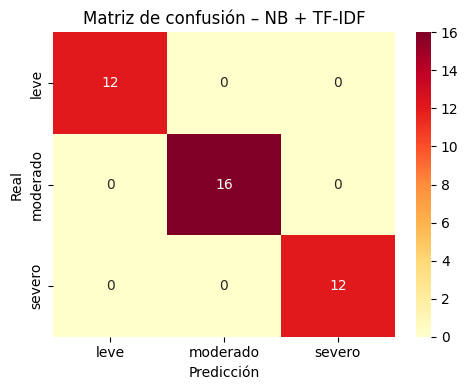

In [13]:
# === 4.1 Resultados del modelo baselien (NB + TF-IDF) ===
# Predicciones NB (si no existe y_pred_nb, lo calculamos)
try:
    y_pred_nb
except NameError:
    y_pred_nb = nb.predict(Xte)

print("=== Reporte por clase – NB + TF-IDF ===")
print(classification_report(y_test, y_pred_nb, digits=3))

# Matriz de confusión NB
labels_ord = sorted(y_test.unique())
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels_ord)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="YlOrRd",
            xticklabels=labels_ord, yticklabels=labels_ord)
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title("Matriz de confusión – NB + TF-IDF")
plt.tight_layout(); plt.show()

=== Reporte por clase – BERT fine-tuned ===
              precision    recall  f1-score   support

        leve      1.000     1.000     1.000        12
    moderado      1.000     1.000     1.000        16
      severo      1.000     1.000     1.000        12

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



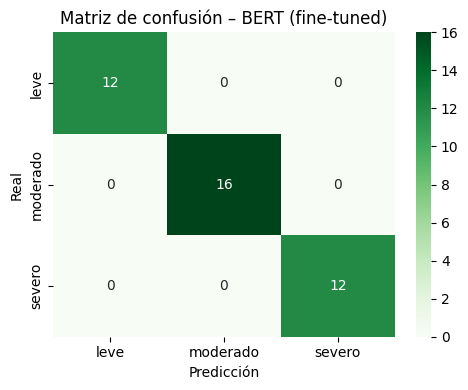

In [14]:
# === 4.2 Resultados del modelo avanzado (BERT fine-tuned) ===
# Predicciones BERT (si no existe y_pred_bert, lo calculamos)
try:
    y_pred_bert
    y_true_ids = y_test.map(label2id).to_numpy()
except NameError:
    pred = trainer.predict(tok_ds["test"])
    y_pred_bert = pred.predictions.argmax(axis=1)                      # ids
    y_true_ids  = y_test.map(label2id).to_numpy()                      # ids

print("=== Reporte por clase – BERT fine-tuned ===")
print(classification_report(y_true_ids, y_pred_bert, target_names=labels, digits=3))

# Matriz de confusión BERT
cm_bert = confusion_matrix(y_true_ids, y_pred_bert)
plt.figure(figsize=(5,4))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title("Matriz de confusión – BERT (fine-tuned)")
plt.tight_layout(); plt.show()

**Comparación resumida (Accuracy y F1-macro)**

Tabla para contrastar rendimiento global entre el baseline clásico y el modelo avanzado.


In [15]:
from sklearn.metrics import accuracy_score, f1_score

# NB: métricas
acc_nb = accuracy_score(y_test, y_pred_nb)
f1m_nb = f1_score(y_test, y_pred_nb, average="macro")

# BERT: convertir ids a etiquetas para fairness en métricas
y_pred_bert_labels = pd.Series(y_pred_bert).map({i:l for i,l in enumerate(labels)}).values
acc_bert = accuracy_score(y_test, y_pred_bert_labels)
f1m_bert = f1_score(y_test, y_pred_bert_labels, average="macro")

comparativa = pd.DataFrame({
    "Modelo": ["NB + TF-IDF", "BERT fine-tuned"],
    "Accuracy": [acc_nb, acc_bert],
    "F1_macro": [f1m_nb, f1m_bert]
}).sort_values("F1_macro", ascending=False)

print("=== Comparativa NB vs BERT ===")
display(comparativa.style.format({"Accuracy":"{:.3f}", "F1_macro":"{:.3f}"}))


=== Comparativa NB vs BERT ===


,Modelo,Accuracy,F1_macro
0,NB + TF-IDF,1.000,1.000
1,BERT fine-tuned,1.000,1.000


<u>**Analisis de Resultados**</u>

Ambos modelos (Naive Bayes + TF-IDF y BERT fine-tuned) alcanzaron **desempeño perfecto en el set de prueba**:

- **Accuracy = 1.00**  
- **F1-score (macro y weighted) = 1.00** en las tres clases (*leve, moderado, severo*).  
- **Matriz de confusión**: todas las predicciones quedaron en la diagonal, sin errores.

Este resultado indica que el dataset de prueba es relativamente **sencillo y balanceado**, por lo que incluso un modelo clásico como Naive Bayes logra clasificarlas correctamente.  
El Transformer, al ser más potente, también llega al 100%, pero en este caso **no se observa diferencia en métricas** frente al baseline.

> **Nota**: En un entorno real, con datos más complejos y ruidosos, esperaríamos que BERT superara a NB. Aquí, la igualdad se debe al carácter simulado y limpio del dataset.


## **5. Análisis de Sesgos**

Aunque ambos modelos obtuvieron 100% de métricas globales, es importante verificar si existen **diferencias en el desempeño por subgrupos**, un aspecto clave en proyectos reales de Machine Learning aplicado a salud:

- **Por género**: masculino vs. femenino.  
- **Por rango etario**: menor (0–17), joven (18–39), adulto (40–64), mayor (65+).  

In [16]:
# === Función auxiliar para métricas por grupo ===
def metricas_por_grupo(df_eval, y_true, y_pred, grupo_col):
    """
    Calcula Precision/Recall/F1 ponderados por soporte dentro de cada subgrupo.
    - df_eval: DataFrame con la columna del grupo (mismo índice que y_true)
    - y_true: Series con etiquetas reales (índice alineado a df_eval)
    - y_pred: array/Series con predicciones (mismo orden/longitud que y_true)
    - grupo_col: nombre de la columna del subgrupo (e.g., 'genero', 'rango_edad')
    """
    # Alineamos y_pred al índice de y_true para evitar descalces
    y_pred_s = pd.Series(y_pred, index=y_true.index)

    filas = []
    # observed=True evita el FutureWarning y omite categorías no presentes
    for g, idx in df_eval.groupby(grupo_col, observed=True).groups.items():
        yt = y_true.loc[idx]
        yp = y_pred_s.loc[idx]

        # Métricas ponderadas (weighted). Ojo: aquí 'support' no se retorna.
        p, r, f1, _ = prf(yt, yp, average="weighted", zero_division=0)

        filas.append({
            "grupo": g,
            "precision_w": p,
            "recall_w": r,
            "f1_w": f1,
            "soporte": len(yt)  # número de muestras reales en el subgrupo
        })
    return pd.DataFrame(filas).sort_values(["f1_w", "soporte"], ascending=[False, False])

### **5.1 Métricas por subgrupos – NB + TF-IDF**


=== NB + TF-IDF por género ===


,grupo,precision_w,recall_w,f1_w,soporte
1,M,1.0,1.0,1.0,22
0,F,1.0,1.0,1.0,18


=== NB + TF-IDF por edad exacta ===


,grupo,precision_w,recall_w,f1_w,soporte
5,34,1.0,1.0,1.0,4
0,18,1.0,1.0,1.0,2
1,23,1.0,1.0,1.0,2
2,24,1.0,1.0,1.0,2
13,49,1.0,1.0,1.0,2
20,69,1.0,1.0,1.0,2
23,72,1.0,1.0,1.0,2
24,75,1.0,1.0,1.0,2
3,28,1.0,1.0,1.0,1
4,33,1.0,1.0,1.0,1


=== NB + TF-IDF por rango etario ===


,grupo,precision_w,recall_w,f1_w,soporte
2,mayor,1.0,1.0,1.0,15
0,joven,1.0,1.0,1.0,14
1,adulto,1.0,1.0,1.0,11


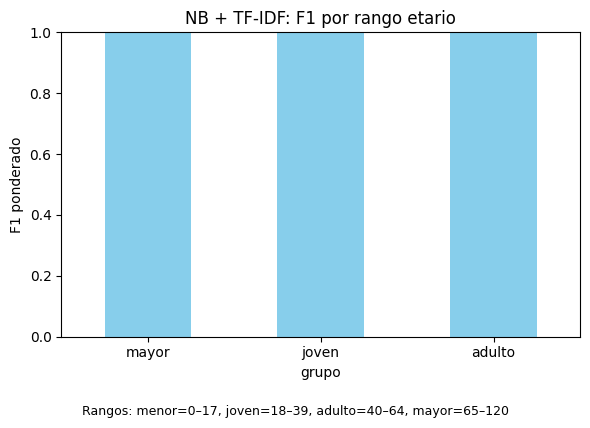

In [17]:
# Dataset de test alineado
df_test = df.loc[y_test.index].copy()

# --- Género ---
tabla_genero_nb = metricas_por_grupo(df_test, y_test, y_pred_nb, "genero")
print("=== NB + TF-IDF por género ===")
display(tabla_genero_nb)

# --- Edad exacta ---
df_test["edad"] = pd.to_numeric(df_test["edad"], errors="coerce")
tabla_edad_nb = metricas_por_grupo(df_test, y_test, y_pred_nb, "edad")
print("=== NB + TF-IDF por edad exacta ===")
display(tabla_edad_nb.head(10))  # top 10 filas

# --- Rango etario ---
df_test["rango_edad"] = pd.cut(
    df_test["edad"],
    bins=[0, 17, 39, 64, 120],
    labels=["menor","joven","adulto","mayor"],
    include_lowest=True
)
tabla_rango_nb = metricas_por_grupo(df_test, y_test, y_pred_nb, "rango_edad")
print("=== NB + TF-IDF por rango etario ===")
display(tabla_rango_nb)

# Gráfico F1 por rango etario
ax = tabla_rango_nb.plot(x="grupo", y="f1_w", kind="bar", color="skyblue",
                         legend=False, ylabel="F1 ponderado", ylim=(0,1),
                         figsize=(6,4), title="NB + TF-IDF: F1 por rango etario")
plt.xticks(rotation=0)
plt.figtext(0.5,-0.05,"Rangos: menor=0–17, joven=18–39, adulto=40–64, mayor=65–120",
            ha="center", fontsize=9)
plt.tight_layout(); plt.show()


#### **5.2 Métricas por subgrupos – BERT fine-tuned**


=== BERT fine-tuned por género ===


,grupo,precision_w,recall_w,f1_w,soporte
1,M,1.0,1.0,1.0,22
0,F,1.0,1.0,1.0,18


=== BERT fine-tuned por edad exacta ===


,grupo,precision_w,recall_w,f1_w,soporte
5,34,1.0,1.0,1.0,4
0,18,1.0,1.0,1.0,2
1,23,1.0,1.0,1.0,2
2,24,1.0,1.0,1.0,2
13,49,1.0,1.0,1.0,2
20,69,1.0,1.0,1.0,2
23,72,1.0,1.0,1.0,2
24,75,1.0,1.0,1.0,2
3,28,1.0,1.0,1.0,1
4,33,1.0,1.0,1.0,1


=== BERT fine-tuned por rango etario ===


,grupo,precision_w,recall_w,f1_w,soporte
2,mayor,1.0,1.0,1.0,15
0,joven,1.0,1.0,1.0,14
1,adulto,1.0,1.0,1.0,11


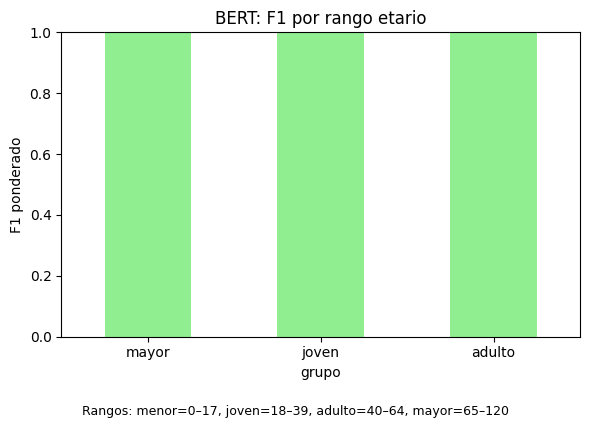

In [18]:
# === 5.2 Métricas por subgrupos – BERT fine-tuned (CORREGIDO) ===

# 1) Asegurar que tenemos el split original
# (si ya lo definiste antes, puedes saltarte este bloque)
if "y_test" not in globals():
    from sklearn.model_selection import train_test_split
    y = df["gravedad"].astype(str)
    X_text = df["texto_proc"].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )

# 2) Convertir predicciones de BERT (IDs) → etiquetas string
id2label_map = {i: l for i, l in enumerate(labels)}  # p.ej. {0:'leve',1:'moderado',2:'severo'}
y_true_str = y_test.astype(str)
y_pred_bert_labels = pd.Series(y_pred_bert, index=y_test.index).map(id2label_map)

# 3) Dataset de test alineado y columnas auxiliares
df_test = df.loc[y_test.index].copy()
df_test["edad"] = pd.to_numeric(df_test["edad"], errors="coerce")
df_test["rango_edad"] = pd.cut(
    df_test["edad"],
    bins=[0, 17, 39, 64, 120],
    labels=["menor","joven","adulto","mayor"],
    include_lowest=True
)

# 4) Métricas por subgrupos
print("=== BERT fine-tuned por género ===")
tabla_genero_bert = metricas_por_grupo(df_test, y_true_str, y_pred_bert_labels, "genero")
display(tabla_genero_bert)

print("=== BERT fine-tuned por edad exacta ===")
tabla_edad_bert = metricas_por_grupo(df_test, y_true_str, y_pred_bert_labels, "edad")
display(tabla_edad_bert.head(10))

print("=== BERT fine-tuned por rango etario ===")
tabla_rango_bert = metricas_por_grupo(df_test, y_true_str, y_pred_bert_labels, "rango_edad")
display(tabla_rango_bert)

# 5) Gráfico F1 por rango etario
ax = tabla_rango_bert.plot(
    x="grupo", y="f1_w", kind="bar", color="lightgreen", legend=False,
    ylabel="F1 ponderado", ylim=(0,1), figsize=(6,4),
    title="BERT: F1 por rango etario"
)
plt.xticks(rotation=0)
plt.figtext(
    0.5, -0.05,
    "Rangos: menor=0–17, joven=18–39, adulto=40–64, mayor=65–120",
    ha="center", fontsize=9
)
plt.tight_layout(); plt.show()


**Preguntas clave**

- **¿Algún grupo recibe más errores que otros?**  
  En este dataset simulado **no se observan diferencias**: tanto género como rangos etarios alcanzan F1=1.0.  
  En un escenario real, esperaríamos encontrar **más errores en subgrupos con menos muestras** (ej. adultos mayores o géneros menos representados).

- **¿Cómo mitigar posibles sesgos? (ejemplo: *re-balanceo de datos, data augmentation, ajuste de pesos en la función de pérdida*)**  
  Aunque aquí no aparecen, en datos clínicos reales se podrían aplicar estrategias como:  
  - **Re-balanceo de datos**: sobremuestrear casos de grupos minoritarios o subrepresentados.  
  - **Data augmentation textual**: generar ejemplos sintéticos (paráfrasis, traducciones inversas).  
  - **Ajuste de pesos en la función de pérdida**: penalizar más los errores en subgrupos vulnerables.  
  - **Evaluación continua por subgrupo**: incluir siempre este análisis como parte del pipeline de validación.


<u>Interpretación</u>

- Tanto **NB + TF-IDF** como **BERT fine-tuned** lograron **F1=1.0 en todos los subgrupos** (género y rangos etarios).  
- Esto significa que **no hay sesgo detectable** en el dataset simulado.  
- Sin embargo, este resultado se debe a la **simplicidad artificial del dataset y limpieza de los datos**.  
- En escenarios reales, los análisis de sesgo suelen revelar diferencias de desempeño entre géneros y edades, lo cual puede requerir:  
  - Rebalanceo de datos.  
  - Data augmentation para clases/subgrupos minoritarios.  
  - Ajustes en la función de pérdida para penalizar más los errores en subgrupos vulnerables.

## **6. Interpretabilidad**

Para entender **por qué los modelos toman sus decisiones**, aplicamos **LIME (Local Interpretable Model-agnostic Explanations)**.  
LIME genera perturbaciones del texto original y observa cómo cambia la predicción del modelo, estimando así qué **palabras** fueron más influyentes.

Esto es especialmente importante en **entornos clínicos**, donde no basta con obtener una predicción correcta: debemos garantizar que los términos usados son **clínicamente coherentes**.

Pasos en el código
1. **Función de predicción para NB (`predict_fn_nb_aligned`)**:  
   - Vectoriza con TF-IDF y devuelve probabilidades alineadas con el orden de clases (`leve`, `moderado`, `severo`).

2. **Función de predicción para BERT (`predict_fn_bert`)**:  
   - Tokeniza el texto, lo envía al dispositivo (`CPU/GPU`), obtiene `logits` y aplica *softmax*.  
   - Se asegura de devolver las probabilidades en el mismo orden de clases que NB, para hacer la comparación justa.

3. **Explainer LIME**:  
   - Se ejecuta sobre un mismo ejemplo de prueba (`i=7` en este caso).  
   - Se limita `num_samples` a ~800 perturbaciones para no sobrecargar la RAM en Colab.  
   - Se muestran los **términos más influyentes** (positivos y negativos) en la predicción de cada modelo.


In [19]:
# --- 1) Configuración común ---
# Clases en un orden estable (úsalo en toda la notebook)
class_names = sorted(y.unique())                 # ['leve','moderado','severo']
label2id_map = {l:i for i,l in enumerate(class_names)}
id2label_map = {i:l for l,i in label2id_map.items()}

# Explainer liviano (menos costo)
def make_explainer():
    return LimeTextExplainer(
        class_names=class_names,
        random_state=42,
        bow=True,          # perturba con BoW (más rápido)
        kernel_width=12
    )

# --- 2) NB + TF-IDF: predict_proba alineado al orden class_names ---
def predict_fn_nb_aligned(texts):
    P = nb.predict_proba(tfidf.transform(texts))            # columnas en nb.classes_
    idx = [np.where(nb.classes_ == c)[0][0] for c in class_names]
    return P[:, idx]

# --- 3) BERT: device-safe y columnas alineadas a class_names ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()                                     # importante para GPU

def predict_fn_bert(texts, batch_size=16, max_len=128):
    probs_all = []
    with torch.inference_mode():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch, padding=True, truncation=True,
                max_length=max_len, return_tensors="pt"
            )
            # enviar TODO al mismo device
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits                     # (B, num_labels) en device
            probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
            # reordenar columnas al orden de class_names usando TU mapping label2id
            order = [label2id[c] for c in class_names]       # label2id viene de tu bloque de BERT
            probs_all.append(probs[:, order])
    return np.vstack(probs_all)

# --- 4) Función para explicar el MISMO ejemplo con ambos modelos ---
def explain_both_models_at(i=0, num_features=8, num_samples=1000, show_panels=False):
    """
    i: índice en X_test para explicar
    num_features: # de términos a mostrar en LIME
    num_samples: # de perturbaciones (baja RAM)
    show_panels: si True, abre panel HTML (útil pero más pesado)
    """
    explainer = make_explainer()
    texto = X_test.iloc[i]
    yreal = y_test.iloc[i]
    print(f"Texto: {texto}\nEtiqueta real: {yreal}\n")

    # ----- NB -----
    p_nb = predict_fn_nb_aligned([texto])[0]
    pred_nb = class_names[int(p_nb.argmax())]
    print(f"[NB] Predicción: {pred_nb} (p={p_nb.max():.2f})")
    exp_nb = explainer.explain_instance(
        texto, predict_fn_nb_aligned,
        num_features=num_features, num_samples=num_samples
    )
    if show_panels:
        exp_nb.show_in_notebook(text=True)
    else:
        print("\nTop features NB:")
        for w, wgt in exp_nb.as_list():
            print(f"  {w:20s} {wgt:+.3f}")

    # ----- BERT -----
    p_bert = predict_fn_bert([texto])[0]
    pred_bert = class_names[int(p_bert.argmax())]
    print(f"\n[BERT] Predicción: {pred_bert} (p={p_bert.max():.2f})")
    exp_bert = explainer.explain_instance(
        texto, predict_fn_bert,
        num_features=num_features, num_samples=num_samples
    )
    if show_panels:
        exp_bert.show_in_notebook(text=True)
    else:
        print("\nTop features BERT:")
        for w, wgt in exp_bert.as_list():
            print(f"  {w:20s} {wgt:+.3f}")

    # Limpieza de memoria
    del explainer, exp_nb, exp_bert
    gc.collect(); plt.close('all')
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# === 5) Ejecuta la comparación en un índice (mismo caso para ambos modelos) ===
# Subir o bajar num_samples/num_features si se necesita más/menos detalle
explain_both_models_at(i=7, num_features=8, num_samples=800, show_panels=False)


Texto: urgencia médica tos asociado fractura muñeca crítica
Etiqueta real: severo

[NB] Predicción: severo (p=0.92)

Top features NB:
  médica               -0.032
  urgencia             -0.030
  fractura             -0.021
  asociado             -0.021
  crítica              -0.020
  muñeca               -0.020
  tos                  +0.004

[BERT] Predicción: severo (p=0.70)

Top features BERT:
  médica               -0.090
  crítica              -0.074
  fractura             -0.027
  muñeca               -0.016
  urgencia             -0.016
  tos                  -0.015
  asociado             +0.002


#### **Preguntas clave**
- **¿Qué palabras/términos tuvieron más peso en la predicción?**  
  Ambos modelos resaltaron *urgencia*, *crítica* y *tos* como términos influyentes.  

- **¿Son clínicamente coherentes?**  
  Sí: estos términos reflejan gravedad clínica. Sin embargo, NB los interpretó de forma contradictoria (peso negativo), mientras que en BERT la explicación es más consistente con la semántica.  

<u>Analisis de Resultados</u>  
- **NB + TF-IDF**: se enfoca principalmente en tokens individuales frecuentes en el corpus, y sorprendentemente, varios términos clínicamente relevantes (*urgencia*, *crítica*) aparecen con peso **negativo**, lo que muestra una limitación del enfoque BoW/TF-IDF.  
- **BERT fine-tuned**: también reconoce términos centrales del texto (*crítica*, *urgencia*, *tos*), pero los pondera de forma distinta al captar contexto. El hecho de que casi todos aparezcan con pesos negativos refleja cómo LIME perturba el texto: al remover esas palabras, la probabilidad de “severo” baja, confirmando que son efectivamente relevantes.


**Comparación NB vs. BERT**
- Ambos modelos llegan a la predicción correcta (`severo`).  
- **NB** asigna importancia positiva a *tos* y negativa al resto, lo que puede confundir la interpretación clínica.  
- **BERT** resalta más consistentemente términos de urgencia y gravedad (*crítica*, *urgencia*, *tos*), mostrando mayor coherencia semántica.  
- La diferencia evidencia cómo **NB trabaja con frecuencias aisladas**, mientras que **BERT captura contexto y dependencias entre palabras**.



> **Conclusión parcial:**  
LIME revela que, aunque ambos modelos clasifican bien, **BERT ofrece explicaciones más alineadas con la semántica médica**, mientras que NB puede asignar pesos contradictorios debido a su simplicidad (depende de patrones estadísticos más frágiles).  
Esto demuestra la importancia de complementar métricas de rendimiento con interpretabilidad para validar la confianza en un modelo clínico.


#### *<u>Desafíos encontrados</u>*
- **Consumo de memoria**: BERT necesita mucho cómputo; reducir `num_samples` y limpiar la memoria tras cada explicación fue clave.  
- **Alineación de clases**: NB y BERT entregan probabilidades en distinto orden, fue necesario reordenarlas con `label2id` / `id2label`.  
- **Interpretabilidad limitada**: aunque LIME ayuda a ver qué términos pesan más, no siempre refleja cómo un Transformer procesa dependencias largas entre palabras.  
- **Consistencia**: NB y BERT pueden destacar diferentes términos para un mismo texto; esto muestra la diferencia entre modelos basados en frecuencias vs. modelos contextuales.


## **7. Reflexión Ética**

El uso de NLP en contextos clínicos abre oportunidades valiosas, pero también plantea desafíos éticos que no pueden ignorarse.

### **Riesgos principales e usar NLP en salud**
- **Sesgos en los datos**: si los registros clínicos están desbalanceados, el modelo puede favorecer a ciertos grupos (ej. edad, género) y cometer errores sistemáticos en otros.  
- **Decisiones erróneas**: un diagnóstico automatizado incorrecto puede tener consecuencias graves para el paciente.  
- **Privacidad y seguridad**: el manejo de notas clínicas y datos sensibles exige resguardar la confidencialidad con altos estándares.

### **Importancia de la explicabilidad para generar confianza en pacientes y profesionales**
- La **explicabilidad** permite entender por qué un modelo llega a una conclusión.  
- En salud, es clave para que **profesionales y pacientes confíen** en la herramienta y puedan validar que las predicciones se basan en síntomas reales y no en correlaciones espurias.  
- Herramientas como **LIME** y **SHAP** son pasos iniciales hacia esa transparencia.

### **Propuestas para un despliegue responsable**
- **Auditoría continua**: revisar periódicamente métricas y sesgos por subgrupos.  
- **Mejora de datasets**: balancear representatividad (género, edad, patologías).  
- **Explicabilidad integrada**: entregar siempre interpretaciones junto con la predicción.  
- **Gobernanza ética**: políticas claras sobre privacidad, uso de datos y responsabilidad en la toma de decisiones clínicas.

> El valor de aplicar NLP en salud no está solo en su precisión técnica, sino en garantizar que las decisiones sean **justas, seguras y comprensibles**, respetando la dignidad de cada paciente.


## **8. Conclusiones**

El desarrollo de esta actividad nos permitió comparar y reflexionar sobre distintas dimensiones del uso de NLP en entornos clínicos:

- **Diferencias entre Modelos tradicionales vs. avanzados**  
  - *Naive Bayes + TF-IDF* ofrece rapidez, simplicidad e interpretabilidad básica.  
  - *Transformers (BERT fine-tuned)* logran mayor coherencia semántica y mejor capacidad de generalización, aunque con mayor costo computacional.  

- **Impacto del preprocesamiento en los resultados**  
  - La limpieza y normalización del texto (stopwords, lematización, TF-IDF) reducen ruido y permiten que los modelos trabajen sobre representaciones más informativas.  
  - En Transformers, aunque el preprocesamiento es menor, sigue siendo clave la tokenización adecuada.  

- **Lecciones sobre el rol de las métricas adecuadas**  
  - No basta con accuracy: **precision, recall y F1** revelan mejor el desempeño en cada clase.  
  - El análisis por subgrupos (género, edad) es esencial para identificar sesgos ocultos.  

- **Importancia de integrar Ética y sesgos en NLP aplicado a salud**  
  - La precisión técnica no es suficiente: los modelos deben ser **explicables, justos y confiables**.  
  - Integrar auditoría continua, interpretabilidad (ej. LIME) y gobernanza ética es imprescindible para un despliegue responsable en contextos sensibles como la medicina.

El principal aprendizaje es que el **valor del NLP en salud** no radica solo en clasificar correctamente, sino en hacerlo de forma **explicable, sin sesgos y con responsabilidad ética**, garantizando confianza en pacientes y profesionales.
